<a href="https://colab.research.google.com/github/gilad-altshuler/Beyond_Linear_Summation-Three_Body_RNNs/blob/main/notebooks/1_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Three Way Model
$h_t=\sigma(h_{t-1}^{T}\cdot𝓦\cdot h_{t-1} + I\cdot u_t)$

#imports

In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab. Cloning repo...")
    !git clone https://github.com/gilad-altshuler/Beyond_Linear_Summation-Three_Body_RNNs.git
    %cd Beyond_Linear_Summation-Three_Body_RNNs
    !wget -O Arial.ttf "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"
else:
    print("Not running in Colab.")
    sys.path.append("../")

Running in Colab. Cloning repo...
fatal: destination path 'Beyond_Linear_Summation-Three_Body_RNNs' already exists and is not an empty directory.
/content/Beyond_Linear_Summation-Three_Body_RNNs
--2025-07-28 22:16:02--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2025-07-28 22:16:02--  https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275572 (269K) [application/octet-stream]
Savi

In [2]:
import torch
import random
from torch import nn
import numpy as np

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline
fm.fontManager.addfont('Arial.ttf')
arial_fp = fm.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = arial_fp.get_name()
plt.rcParams["font.size"] = 10
import seaborn as sns

import utils
import tasks.K_Bit_Flipflop_task
from Models import *

In [3]:
DATA_DIR = "data/validation"
FIG_DIR = "notebooks/figures"

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fig. 3 panels preperation

Panel (a) top - PCA analysis

In [6]:
input_size=output_size=K=3
hidden_dim=30
teacher = TBRNN(input_size, output_size, hidden_dim, mode='disc',
                form='voltage',task="FF", Win_bias=True, Wout_bias=True)
teacher.load_state_dict(torch.load(f"{DATA_DIR}/teacher_model.pth",map_location="cpu"))

# # Uncomment for new input, target
# input, target = K_Bit_Flipflop_task.generate_data(4,100,K)
input = torch.load(f"{DATA_DIR}/input.pth")
target = torch.load(f"{DATA_DIR}/target.pth")

In [7]:
colors = np.array([[0.1254902, 0.29019608, 0.52941176],
                   [0.80784314, 0.36078431, 0.],
                   [0.30588235, 0.60392157, 0.02352941],
                   [0.64313725, 0., 0.]])
def show_pca(model, inputs, idx, steps=1):
    """
    :param model: TBRNN model to show 3D PCA of the first 3 trajectories PCs
    :param inputs: inputs to derive the trajectories from
    :param idx: index in input
    :param steps: steps in the PCs
    :param dyn: True if it is dynamical modelling, False otherwise
    :return: None
    """
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.decomposition import PCA
    R = model(inputs, None)[2][idx].cpu()
    if model.mode == 'cont':
        R = model.nonlinearity(R)

    pca = PCA(n_components=3)
    pca.fit(R.detach().numpy())

    variance = pca.explained_variance_ratio_.cumsum()

    V = pca.transform(R.detach().numpy()) * 1.15

    fig = plt.figure(figsize=(2, 1), dpi=300)
    ax = fig.add_subplot(122, projection='3d')

    ax.set_box_aspect([1, 1, 1])
    ax.dist = 4

    # Stretch the subplot to fill more space
    box = ax.get_position()
    ax.set_position([box.x0 - 0.05, box.y0 - 0.05, box.width * 1.2, box.height * 1.2])

    # Now plot
    ax.plot(V[::steps, 0], V[::steps, 1], V[::steps, 2], '-o', color=colors[0], markersize=0.25,linewidth=0.5)

    # Remove all ticks and frame
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax._axis3don = False  # hides grid, axes panes etc.

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')

    offset = 1.0

    ax.set_xlim(V[:, 0].min()+offset, V[:, 0].max()-offset)
    ax.set_ylim(V[:, 1].min()+offset, V[:, 1].max()-offset)
    ax.set_zlim(V[:, 2].min()+offset, V[:, 2].max()-offset)


    ax2 = fig.add_subplot(121, projection='3d')

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2._axis3don = False
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_zlabel('')


    # Add custom arrows for axes
    arrow_length = 3.5
    shift = 50
    origin = [-shift, -shift, -shift]
    colors_arr = ['black', 'black', 'black']

    # PC1 arrow
    ax2.quiver(*origin, arrow_length, 0, 0, color=colors_arr[0], arrow_length_ratio=0.2, linewidth=1)
    ax2.text(-shift + arrow_length + 0.1, -shift, -shift, 'PC1', fontsize=8, weight='bold')

    # PC2 arrow
    ax2.quiver(*origin, 0, arrow_length, 0, color=colors_arr[1], arrow_length_ratio=0.2, linewidth=1)
    ax2.text(-shift, -shift + arrow_length + 0.1, -shift, 'PC2', fontsize=8, weight='bold')

    # PC3 arrow
    ax2.quiver(*origin, 0, 0, arrow_length, color=colors_arr[2], arrow_length_ratio=0.2, linewidth=1)
    ax2.text(-shift, -shift, -shift + arrow_length + 0.1, 'PC3', fontsize=8, weight='bold')

    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.tight_layout(pad=0.12)
    plt.savefig("PCA.png", dpi=300, bbox_inches='tight')
    plt.show()

    from PIL import Image, ImageOps

    # Load the image
    img = Image.open("PCA.png")

    # Assume DPI is 300
    dpi = 300
    current_width_px, current_height_px = img.size

    # Step 1: Crop height from 1.08in → 1.00in
    target_height_px = int(1.00 * dpi)
    crop_y_total = current_height_px - target_height_px
    crop_y_top = crop_y_total // 2
    crop_y_bottom = crop_y_total - crop_y_top
    img_cropped = img.crop((0, crop_y_top, current_width_px, current_height_px - crop_y_bottom))

    # Step 2: Pad width from 2.10in → 3.00in
    target_width_px = int(3.00 * dpi)
    pad_x_total = target_width_px - img_cropped.size[0]
    pad_x_left = pad_x_total // 2
    pad_x_right = pad_x_total - pad_x_left
    img_padded = ImageOps.expand(img_cropped, border=(pad_x_left, 0, pad_x_right, 0), fill="white")

    # Save with correct DPI
    img_padded.save(f"{FIG_DIR}/PCA.png", dpi=(dpi, dpi))
    return pca

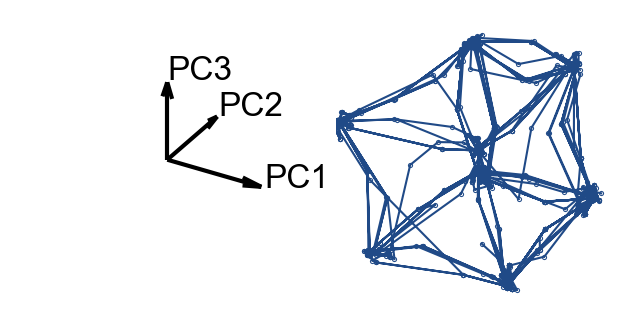

In [8]:
## Uncomment to generate long input.
# input_size=output_size=K=3
# tinput,_=K_Bit_Flipflop_task.generate_data(1,2000,K)
tinput = torch.load(f"{DATA_DIR}/tinput.pth")
_=show_pca(teacher,tinput,0)

Panel (a) bottom - 3 Bit Flipflop visualization

In [9]:
def plot(input,target,prediction=None,idx=0):
    """
    Draw memory charts for the K-Bit Flipflop task.
    :param input: Input tensor of shape (batch_size, time_steps, K)
    :param target: Target tensor of shape (batch_size, time_steps, K)
    :param prediction: Prediction tensor of shape (batch_size, time_steps, K) (optional)
    :param idx: Index of the sample to plot (default is 0)
    :return: None
    """
    K = input.shape[2]
    fig = plt.figure(figsize=(3,2), dpi=300)
    sns.set(style="whitegrid", font_scale=1)
    axes = fig.subplots(K,1,sharex=True, sharey=True)
    inp = input[idx].transpose(0,1)
    tar = target[idx].transpose(0,1)
    pred = prediction[idx].transpose(0,1) if (prediction!=None) else None
    time_steps = np.arange(input.shape[1])
    for i in range(K):
      if K>1:
        ax = axes[i]
      else:
        ax = fig.add_subplot(1,1,1)
      ax.bar(time_steps, inp[i],width=3.0, alpha=0.6,label="spikes")
      ax.axhline()
      ax.plot(time_steps,tar[i],'--g',linewidth=3., alpha=0.7,label="target")
      ax.set_yticks([-1,0,1])

      ax.set_ylabel(f"In {i+1}", fontsize=10,labelpad=1)
      ax.tick_params(labelsize=8,axis='both', which='major', pad=0)
      if(pred!=None):
          ax.plot(time_steps,pred[i].detach().numpy(),'-r',linewidth=1,label="predicted")

    ax.set_xlabel("Time",fontsize=10,labelpad=0)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0,1,1,-0.07), fontsize=8,frameon=False,ncol=3,columnspacing=1.4)
    fig.subplots_adjust(top=0.83, bottom=0.17, hspace=0.2)
    plt.savefig(f"{FIG_DIR}/3bitff.png", dpi=300, bbox_inches='tight')
    plt.show()

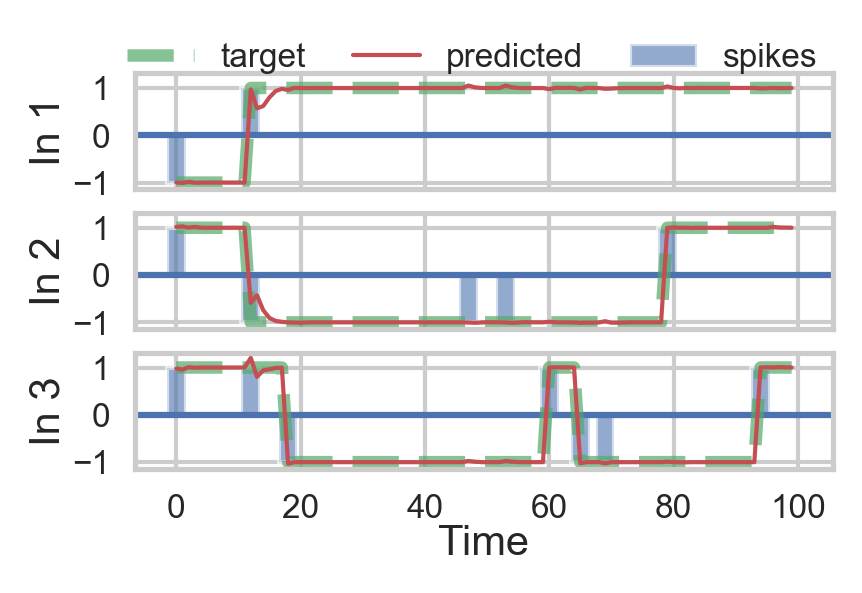

In [10]:
plot(input,target,teacher(input,None)[0],0)

Panel (b) top - External decompositions.png image made by diagrams.net

Panel (b) bottom - Reduction methods comparison

In [11]:
methods = ["LINT","Slice-TCA","TT","TCA"]
accs = {m : np.load(f"{DATA_DIR}/all_{m}.npy").T for m in methods}

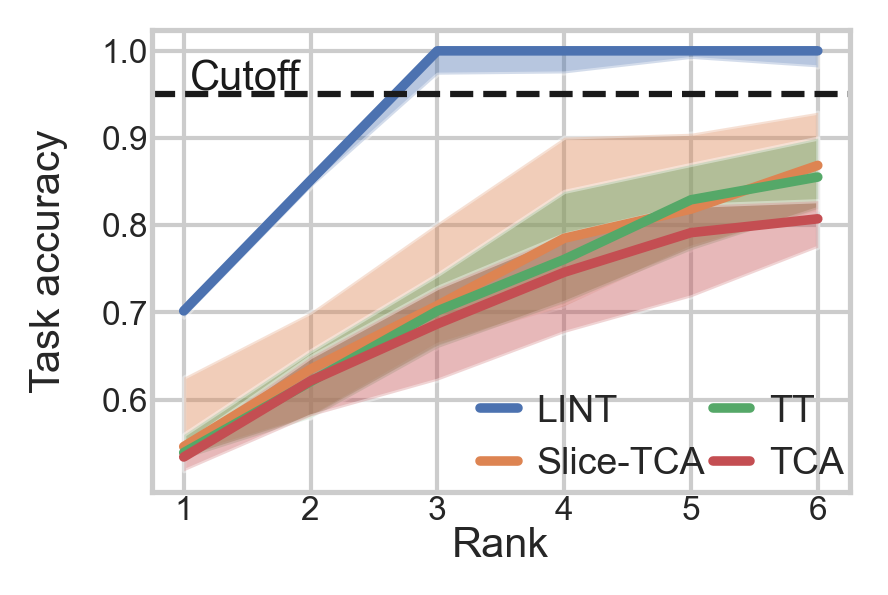

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
ranks = 6
r = np.arange(1, ranks + 1)

records = []
for method, acc in accs.items():
    median = np.median(acc, axis=-1)
    q25 = np.percentile(acc, 25, axis=-1)
    q75 = np.percentile(acc, 75, axis=-1)
    for i in range(ranks):
        records.append({
            "Rank": r[i],
            "Accuracy": median[i],
            "q25": q25[i],
            "q75": q75[i],
            "Method": method
        })

df = pd.DataFrame(records)

# Plot using seaborn
plt.figure(figsize=(3, 2), dpi=300)
sns.set(style="whitegrid", font_scale=1)

# Plot each method with ribbon
for method in df["Method"].unique():
    sub = df[df["Method"] == method]
    sns.lineplot(data=sub, x="Rank", y="Accuracy", label=method, linewidth=2.3)
    plt.fill_between(
        sub["Rank"], sub["q25"], sub["q75"], alpha=0.4,
        label=None  # avoids duplicate legend
    )

# Add horizontal cutoff line
plt.axhline(y=0.95, linestyle="--", color="k")
plt.text(1.05, 0.955, "Cutoff", fontsize=10, color="k")

# Labels and formatting
plt.xlabel("Rank", fontsize=10,labelpad=0)
plt.ylabel("Task accuracy", fontsize=10,labelpad=8)
plt.xticks(list(range(1,ranks+1)),fontsize=8)
plt.yticks([.6,.7,.8,.9,1.],fontsize=8)
plt.tick_params(axis='both', which='major', pad=-5)

legend = plt.legend(frameon=False,fontsize=9,loc='lower right',bbox_to_anchor=(1.04, -0.05),ncol=2,columnspacing=0.2,handletextpad=0.5,handlelength=1.0)
# fig.subplots_adjust(left=0.05,right=0.95,bottom=0.1,top=0.9)
plt.savefig(f"{FIG_DIR}/lint.png", dpi=300, bbox_inches='tight')
plt.show()


### $\mathcal{W}_{eff}$ validation

In [13]:
input_size = output_size =K= 1
hidden_dim=30
data_size = 128
epochs = 10000
T=100
lr_tbrnn_t = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=1,
                            mode='cont', form='rate', task="FF",noise_std=0.0,
                            tau=0.2, Win_bias=True, Wout_bias=True,hard_orth=True).to(DEVICE)

# optimizer = torch.optim.Adam(lr_tbrnn_t.parameters(), lr=5e-4)
# criterion = nn.MSELoss().to(DEVICE)

# input, target = K_Bit_Flipflop_task.generate_data(data_size,T,K)

# # Uncomment to train
# _ = train(lr_tbrnn_t,input,target,epochs,optimizer,criterion,
#                 scheduler=None,mask_train=None,batch_size=data_size,T=T,
#                 hidden=None,clip_gradient=None,keep_best=True,plot=True)

lr_tbrnn_t.load_state_dict(torch.load(f"{DATA_DIR}/lr_tbrnn_t.pth",map_location="cpu"))

<All keys matched successfully>

In [14]:
lr_tbrnn_s = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=1,
                            mode='cont', form='rate', task="FF",noise_std=0.0,
                            tau=0.2, Win_bias=True, Wout_bias=True,hard_orth=True).to(DEVICE)
lr_tbrnn_s.load_state_dict(torch.load(f"{DATA_DIR}/lr_student_rank_1.pth",map_location="cpu"))

<All keys matched successfully>

In [15]:
# # uncomment to train the model
# from pathlib import Path
# to_save = Path(".")
# accs = low_rank_procedures.LINT_method(lr_tbrnn_t,Low_Rank_TBRNN,input,target,start_rank=1,end_rank=1,epochs=30000,batch_size = data_size,lr = [1e-02,1e-03],to_save=to_save)

In [16]:
lr_tbrnn_t.L = torch.nn.Parameter(utils.project_L_orthogonal_to_I(lr_tbrnn_t.L,lr_tbrnn_t.w_in.weight,lr_tbrnn_t.w_in.bias))
lr_tbrnn_s.L = torch.nn.Parameter(utils.project_L_orthogonal_to_I(lr_tbrnn_s.L,lr_tbrnn_s.w_in.weight,lr_tbrnn_s.w_in.bias))
lr_tbrnn_t.hard_orth = False
lr_tbrnn_s.hard_orth = False

W_eff_t,W_t = utils.get_effective_tensor(lr_tbrnn_t)
W_eff_s,W_s = utils.get_effective_tensor(lr_tbrnn_s)

Panel (c) - $\mathcal{W}$ is equivalence class ($\mathcal{W_{eff}}$)

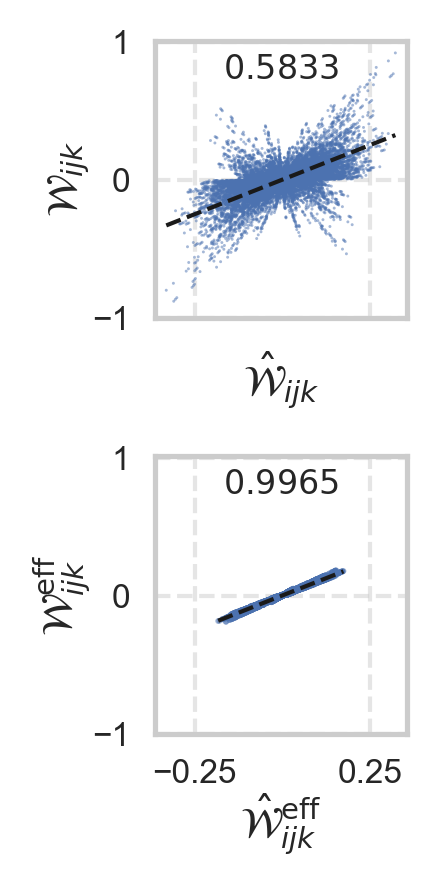

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def corrvecs(v, w):
    return v @ w / (np.linalg.norm(v) * np.linalg.norm(w))

# Flatten
veff, weff = W_eff_t.ravel(), W_eff_s.ravel()
vfull, wfull = W_t.ravel(), W_s.ravel()

# Compute correlations
corr_eff = corrvecs(veff, weff)
corr_full = corrvecs(vfull, wfull)

# Shared plot settings
sns.set(style="whitegrid", font_scale=1)
fig, axes = plt.subplots(2, 1, figsize=(1.5, 3), dpi=300, sharex=True, sharey=True)

# Plot 1: W
axes[0].scatter(vfull, wfull, alpha=0.5, s=0.5, edgecolors='none')
axes[0].plot([vfull.min(), vfull.max()], [vfull.min(), vfull.max()], 'k--', linewidth=1)
axes[0].set_xlabel(r'$\hat{\mathcal{W}}_{ijk}$', fontsize=10,labelpad=7.5)
axes[0].set_ylabel(r'$\mathcal{W}_{ijk}$', fontsize=10,labelpad=0.0)
axes[0].text(0.27, 0.95, f'${corr_full:.4f}$',
             transform=axes[0].transAxes, fontsize=8, verticalalignment='top')

# Plot 2: W_eff
axes[1].scatter(veff, weff, alpha=0.5, s=2., edgecolors='none')
axes[1].plot([veff.min(), veff.max()], [veff.min(), veff.max()], 'k--', linewidth=1)
axes[1].set_xlabel(r'$\hat{\mathcal{W}}^{\mathrm{eff}}_{ijk}$', fontsize=10,labelpad=0.5)
axes[1].set_ylabel(r'$\mathcal{W}^{\mathrm{eff}}_{ijk}$', fontsize=10,labelpad=0.0)
axes[1].text(0.27, 0.95, f'${corr_eff:.4f}$',
             transform=axes[1].transAxes, fontsize=8, verticalalignment='top')

# Layout
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8,axis='both', which='major', pad=0)
    ax.set_yticks([-1.0,0.0,1.0])
    ax.set_xticks([-0.25,0.25])

# plt.tight_layout()
fig.subplots_adjust(left=0.22, right=0.78, hspace=0.5)
plt.savefig(f"{FIG_DIR}/w_eff.png", dpi=300, bbox_inches='tight')
plt.show()


# Combine the panels to full plot

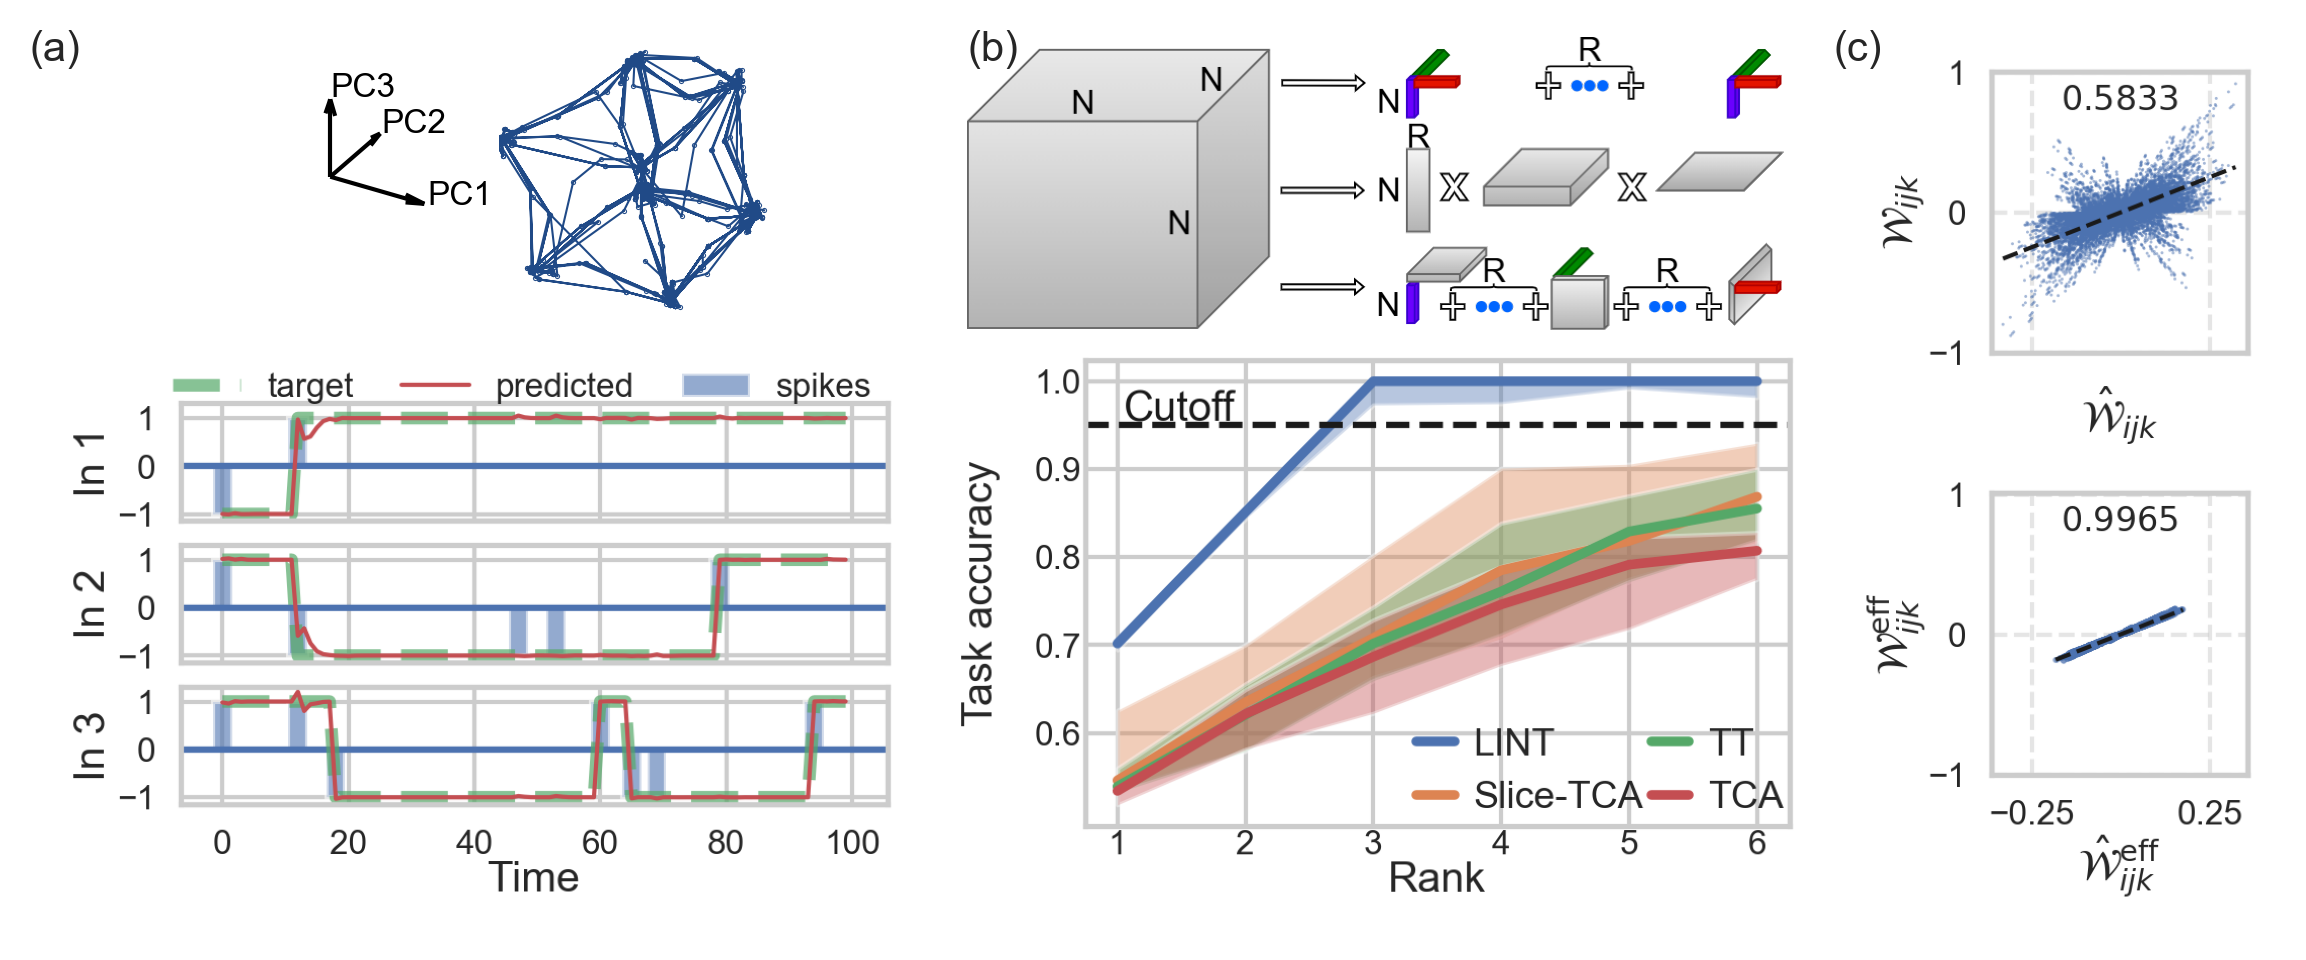

In [18]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

fig, axes = plt.subplot_mosaic(
    [["PCA", "decompositions", "w_eff"],
     ["3bitff", "lint", "w_eff"]],
    gridspec_kw={"width_ratios": [2, 2, 1], "height_ratios": [1, 2]},
    figsize=(7.5, 3),
    dpi = 300)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plots = ["PCA", "decompositions", "w_eff", "3bitff", "lint"]

for plot in plots:
    img = Image.open(f"{FIG_DIR}/{plot}.png")
    axes[plot].imshow(img)
    axes[plot].axis("off")

# Add subplot labels
labels = ['(a)', '(b)', '(c)']
for ax, label in zip(list(axes.values())[:3], labels):
    ax.text(
        0.0, 1.0, label, transform=ax.transAxes,
        fontsize=10, fontweight='bold', va='top', ha='left'
    )

fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.savefig(f"{FIG_DIR}/Theory Validation.tiff", dpi=300, format='tiff', bbox_inches=None, pad_inches=0)
plt.savefig(f"{FIG_DIR}/Theory Validation.png", dpi=300, format='png', bbox_inches=None, pad_inches=0)
plt.show()

In [19]:
# Check the image proportions
from PIL import Image

# Load image
img = Image.open(f"{FIG_DIR}/Theory Validation.tiff")

# Get pixel dimensions
width_px, height_px = img.size
print(f"Pixel dimensions: {width_px} × {height_px} pixels")

# Get DPI info (if embedded)
dpi = img.info.get('dpi', (300, 300))  # Default fallback to 300
print(f"DPI: {dpi[0]} x {dpi[1]}")

# Convert to inches
width_in = width_px / dpi[0]
height_in = height_px / dpi[1]
print(f"Size in inches: {float(width_in):.2f} × {float(height_in):.2f} inches")

Pixel dimensions: 2250 × 900 pixels
DPI: 300.0 x 300.0
Size in inches: 7.50 × 3.00 inches
